In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
load_wine().keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [3]:
df = pd.DataFrame(load_wine()['data'], columns=load_wine()['feature_names'])
df['label']=load_wine()['target']

df.shape

(178, 14)

In [4]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [5]:
df['label'].value_counts()

1    71
0    59
2    48
Name: label, dtype: int64

Checking range of variables since clustering are **distance-based algorithms**.

In [6]:
ranges = list(map(lambda x: np.ptp(df[x]), df.columns))

pd.DataFrame(ranges, index=df.columns, columns=['range'])

,range
alcohol,3.80
malic_acid,5.06
ash,1.87
alcalinity_of_ash,19.40
magnesium,92.00
total_phenols,2.90
flavanoids,4.74
nonflavanoid_phenols,0.53
proanthocyanins,3.17
color_intensity,11.72


In [7]:
cols = list(df.columns)
cols.remove('label')

X=df[cols]
y=df['label']

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Finding **optimal number of clusters** using Inertia and Silhouette Score as metrics. 

In [9]:
def cluster_evaluation(n_clusters):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(X)
    
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X, labels)
    
    return inertia, silhouette

In [10]:
MAX_CLUSTERS = 10
N_CLUSTERS = range(2, MAX_CLUSTERS + 1)

scores = np.array(list(map(lambda x: cluster_evaluation(x), N_CLUSTERS)))

INERTIA = dict(zip(N_CLUSTERS,scores[:,0]))
SILHOUETTE_SCORE = dict(zip(N_CLUSTERS,scores[:,1]))

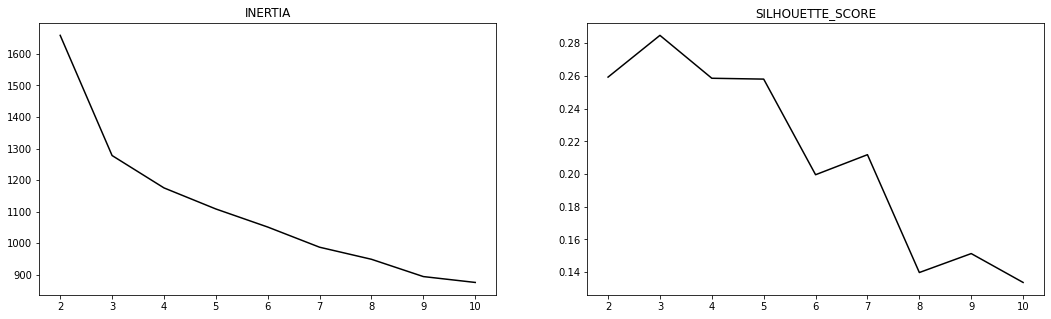

In [11]:
fig=plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(INERTIA.keys(),INERTIA.values(),c='k')
plt.title('INERTIA')

plt.subplot(122)
plt.plot(SILHOUETTE_SCORE.keys(),SILHOUETTE_SCORE.values(),c='k')
plt.title('SILHOUETTE_SCORE')

plt.show()

Find **maximum change in gradient**, also known as elbow method.

In [12]:
INERTIA=pd.DataFrame(INERTIA.values(),index=INERTIA.keys(),columns=['inertia']).reset_index()
INERTIA.rename(columns={'index':'n_clusters'},inplace=True)
INERTIA['gradient']=(INERTIA['inertia'].shift(periods=1)-INERTIA['inertia'])
INERTIA['diff_gradient']=np.abs(INERTIA['gradient']-INERTIA['gradient'].shift(periods=1))
INERTIA.dropna(inplace=True)

INERTIA

,n_clusters,inertia,gradient,diff_gradient
2,4,1175.351881,102.576607,278.253756
3,5,1108.578285,66.773596,35.803011
4,6,1051.308286,57.270000,9.503597
5,7,987.364476,63.943810,6.673810
6,8,949.107071,38.257405,25.686405
7,9,894.338471,54.768600,16.511195
8,10,875.737687,18.600784,36.167816


In [13]:
INERTIA[INERTIA['diff_gradient']==max(INERTIA['diff_gradient'])]

,n_clusters,inertia,gradient,diff_gradient
2,4,1175.351881,102.576607,278.253756


In [14]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)

labels = kmeans.labels_

In [15]:
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(X)

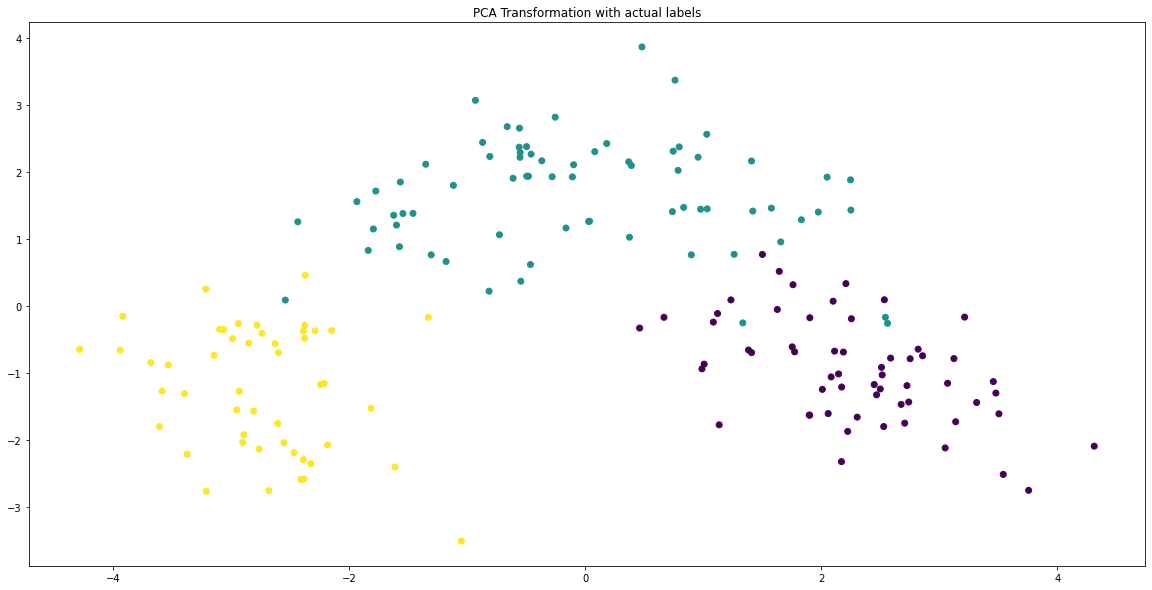

In [16]:
fig = plt.figure(figsize=(20,10))

plt.title('PCA Transformation with actual labels')
plt.scatter(pca_data[:,0], pca_data[:,1], c=y)
plt.show()

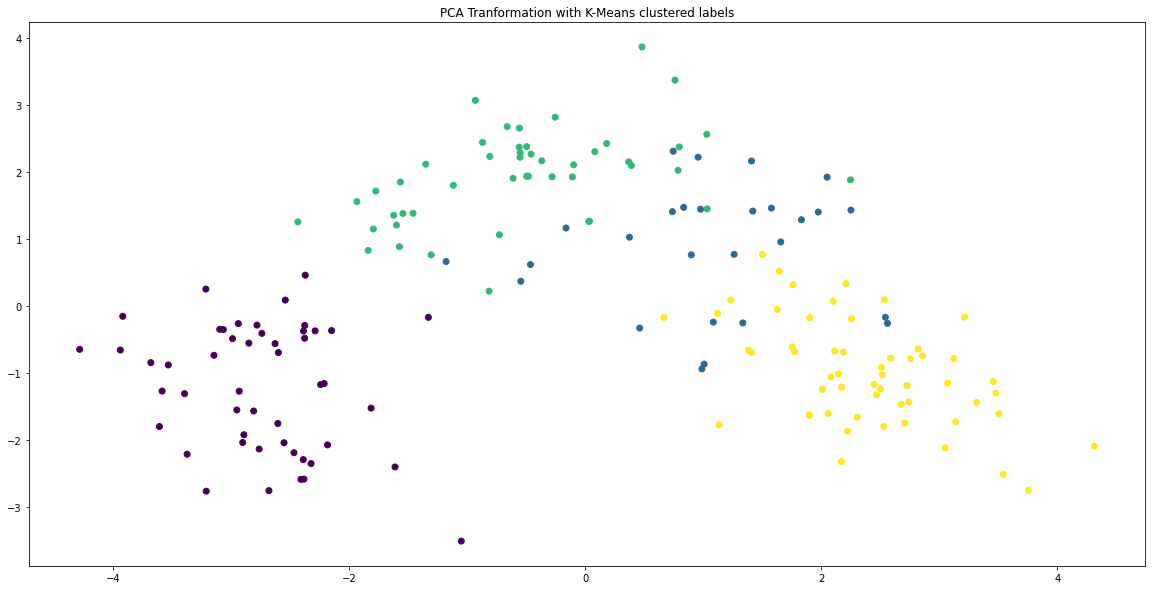

In [17]:
fig = plt.figure(figsize=(20,10))

plt.title('PCA Tranformation with K-Means clustered labels')
plt.scatter(pca_data[:,0], pca_data[:,1], c=labels)
plt.show()

In [18]:
lda = LinearDiscriminantAnalysis()
lda.fit(X,y)

lda.score(X,y)

1.0

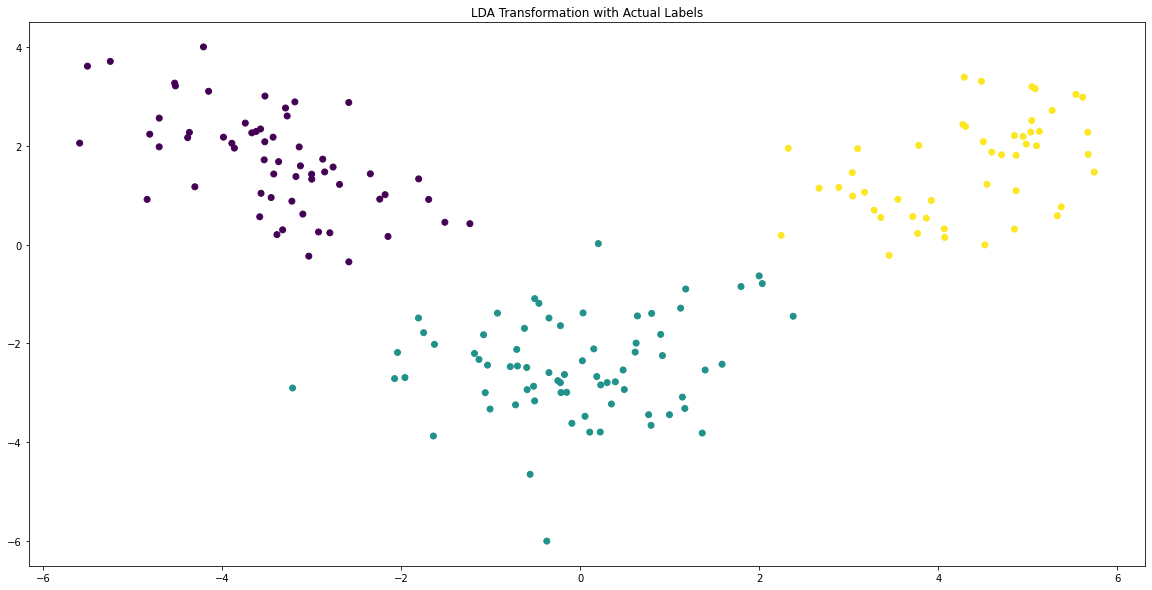

In [19]:
fig = plt.figure(figsize=(20,10))

lda_data = lda.fit_transform(X,y)

plt.title('LDA Transformation with Actual Labels')
plt.scatter(lda_data[:,0],lda_data[:,1], c=y)
plt.show()

This indicates that the data is **linearly separable** as we can separate the classes using a hyperplane. 

Also, we notice that LDA has been able to give a **perfect fit** from the score we are getting.

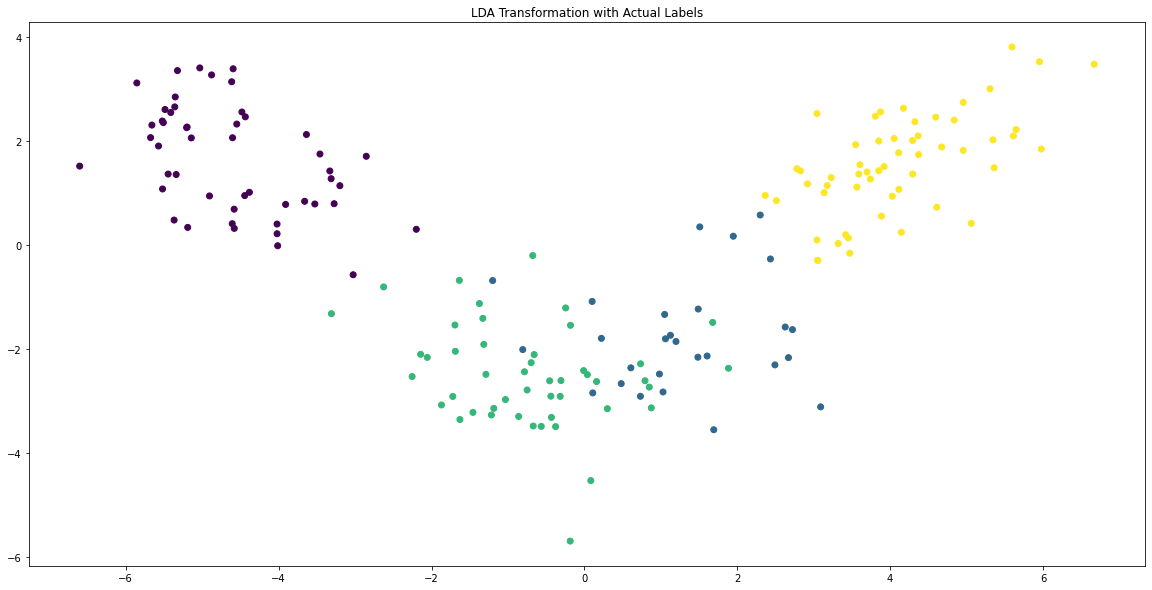

In [20]:
fig = plt.figure(figsize=(20,10))

lda_data = lda.fit_transform(X,labels)

plt.title('LDA Transformation with Actual Labels')
plt.scatter(lda_data[:,0],lda_data[:,1], c=labels)
plt.show()

In [21]:
lda = LinearDiscriminantAnalysis()
lda.fit(X,labels)

lda.score(X,labels)

1.0

We notice that using K-Means clustering labels, we are nearly able to separate data linearly, i.e. the data (with clustering labels as classes) is **nearly linear separable**. 

We can notice the same from the LDA score.